# Radar proccessing

In [1]:
%matplotlib inline
import numpy as np

## Creation of the signal

In [2]:
from blocksim.dsp.DSPSignal import DSPSignal

# Reference chirp generation
tau = 10e-6  # Duration of one pulse
bp = 5e6  # Bandwidth
fs = bp * 3  # Sampling frequency
eta = 0.1  # Duty cycle of repetitions
nrep = 50  # Number of repetitions
fdop = 1e3  # Doppler frequency
wl = 0.2  # wavelength

rep = DSPSignal.fromLinearFM(
    name="rep",
    samplingStart=0,
    samplingPeriod=1 / fs,
    tau=tau,
    fstart=-bp / 2,
    fend=bp / 2,
)

# Noisy received signal with nrep repetitions
ns_rep = len(rep)

ns = int(ns_rep / eta)
tps = np.arange(nrep * ns) / fs
y_sig = np.zeros(nrep * ns, dtype=np.complex128)
for k in range(nrep):
    y_sig[k * ns : k * ns + ns_rep] = rep.y_serie * k
sig = (
    DSPSignal.fromTimeAndSamples(name="sig", tps=tps, y_serie=y_sig)
    .applyDopplerFrequency(fdop=fdop)
    .applyGaussianNoise(pwr=5)
)

[INFO] - Registered blocksim.loggers.CSVLogger
[INFO] - Registered blocksim.loggers.PickleLogger
[INFO] - Registered blocksim.loggers.PsqlLogger
[INFO] - Registered blocksim.loggers.XlsLogger


## Processing

Peak(Radial Velocity (-200.0 m/s delta)=38.7 mm/s, Delay=9.93 µs, value=27.9)


Text(0.5, 1.0, 'Power (dB)')

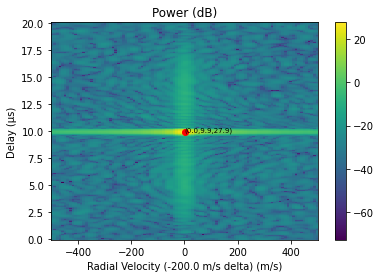

In [3]:
# Definitions
from blocksim.constants import c

Tr = tau / eta  # Repetition period
Tana = nrep * Tr  # Analysis duration
Rf = 1 / Tana  # Frequency resolution
Rv = Rf * wl  # Velocity resolution
Rd = c / bp * 1.4  # Distance resolution
vamb = wl / 2 / Tr  # Size of analyse window in the velocity axis
damb = 2 * tau * c  # Size of analyse window in the distance axis

# Analysis of the received signal
from blocksim.dsp import analyse_DV

spg = analyse_DV(
    wavelength=wl,
    period=Tr,
    dist0=tau * c,
    damb=damb,
    vrad0=-wl * fdop,
    vamb=vamb,
    seq=rep,
    rxsig=sig,
    nv=100,
    corr_window="hamming",
    progress_bar=False,
)

trf = DSPSignal.to_db_lim(-80)
(peak,) = spg.findPeaksWithTransform(transform=trf, nb_peaks=1)
print(peak)

# Plotting
from matplotlib import pyplot as plt
from blocksim.graphics import plotSpectrogram

fig = plt.figure()
axe = fig.add_subplot(111)
_=plotSpectrogram(
    spg,
    axe,
    transform=trf,
    search_fig=False,
    find_peaks=1,
)
axe.set_title("Power (dB)")